  # Project: Loan Default Predictor

In [ ]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
df = pd.read_csv(r'E:\My_Portfolio_Projects\ML Models\Loan_prediction_model\lending_club_loan_two.csv', encoding='utf-8') 
color1 = '#F5F5DC'
color2 = '#4B0082'

 # Data Preprocessing

In [ ]:
df.head(3)

In [ ]:
df.info()

In [ ]:
df.describe()

### Remove Unnecessary Columns

In [ ]:

df.drop(['emp_title' , 'initial_list_status' , 'application_type' , 'mort_acc' , 'address','issue_d','purpose','title'], axis=1 , inplace = True )


### Fix data types  

In [ ]:
df.dtypes

In [ ]:

categorical_cols = ['term', 'grade', 'sub_grade', 'verification_status', 'home_ownership', 
                    'loan_status']
for col in categorical_cols : 
   df[col] =  df[col].astype('category')

In [ ]:
df['loan_amnt'] = df['loan_amnt'].replace({r'\$' : '' , ',' : ''} , regex = True).astype(float)

In [ ]:
df.dtypes

### Understand Missing Data

In [ ]:
df.isnull().sum()

In [ ]:
# checking missing value with heatmap .
plt.figure(figsize=(6,3))
sns.heatmap(df.isnull(), cmap="viridis", cbar=False, yticklabels=False , color = '#4B0082')
plt.show()

### Imputation For Misssing Data

In [ ]:
#   revol_util
# I am gonna Use median because percentage values are numeric and the median is robust to outliers.
df['revol_util'] = df['revol_util'].fillna(df['revol_util'].median())  

In [ ]:
# Fill missing values in 'emp_length' with the most frequent value
df['emp_length'] = df['emp_length'].fillna(df['emp_length'].mode()[0])

In [ ]:
# Fill missing values in 'emp_length' with the most frequent value , Becuase there is a pretty low chance of bankruptcy
mode_value = df['pub_rec_bankruptcies'].mode()
if not mode_value.empty:
    df['pub_rec_bankruptcies'] = df['pub_rec_bankruptcies'].fillna(mode_value[0])
else:
    df['pub_rec_bankruptcies'] = df['pub_rec_bankruptcies'].fillna(mode_value[0])  
    
df['pub_rec_bankruptcies'] = df['pub_rec_bankruptcies'].astype(int)

In [ ]:
plt.figure(figsize=(7,5))
sns.boxplot(data=df[['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti']] , color='#4B0082')
plt.xticks(rotation=45)
plt.title("Box Plot of Numeric Features")
plt.show()

###   Outliers removal

In [ ]:
# we will use IQR for the following columns 'pub_rec', 'dti', 'open_acc' , 'revol_util' Cause its outliers doesn't make sence or they may errors 
df_original = df.copy()

def remove_outliers(df, columns):
    for col in columns:
        
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Filter out the outliers
        before_count = df.shape[0] 
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
        after_count = df.shape[0] 

        print(f"Removed {before_count - after_count} outliers from '{col}'")

    return df 

outlier_con_columns = ['pub_rec', 'dti', 'open_acc' , 'revol_util']
df = remove_outliers(df, outlier_con_columns)

In [ ]:
# we will use 'winsorization' method for those outliers that are not necesserly errors but it's a valueble information.
def winsorization(series , lower_percentile=1 , upper_percentile=99): 
    lower_bond = np.percentile(series , lower_percentile)
    upper_bond = np.percentile(series , upper_percentile)
    return np.clip(series , lower_bond , upper_bond) 

df['loan_amnt'] = winsorization(df['loan_amnt'])
df['int_rate'] = winsorization(df['int_rate'])
df['installment'] = winsorization(df['installment'])
df['total_acc'] = winsorization(df['total_acc'])
df['pub_rec_bankruptcies'] = winsorization(df['pub_rec_bankruptcies'])

In [ ]:
# the two columns revol_bal and annual_income may not have outliers so we will use 'LOG TRANSFORMATION' for skewed data 
df['annual_inc'] = np.log1p(df['annual_inc'])
df['revol_bal'] = np.log1p(df['revol_bal'])

In [ ]:
# Visualize selected numerical columns after cleaning
fig, axes = plt.subplots(2, 3, figsize=(14, 7) )
selected_cols = ['loan_amnt', 'annual_inc', 'dti', 'int_rate', 'revol_bal', 'revol_util']

for i, col in enumerate(selected_cols):
    sns.histplot(df[col], bins=40, kde=True, ax=axes[i//3, i%3] , color='red' )
    axes[i//3, i%3].set_title(f'Distribution of {col} After Outlier Removal')

plt.tight_layout()
plt.show()

###     Feature Engineering

In [ ]:
df_cleaned = df.copy()

In [ ]:
df_cleaned.head(3)

In [ ]:
# new column loan to income ratio
df['loan_to_income_ration'] = df['loan_amnt'] / df['annual_inc']

In [ ]:
# another column installment to income 
df['monthly_inc'] = df['annual_inc'] / 12
df['installment_to_income'] = df['monthly_inc'] / df['installment']

In [ ]:
# credit age
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], format = '%b-%Y' , errors='coerce')
df['credit_age'] = (pd.Timestamp.today() - df['earliest_cr_line']).dt.days / 365.25
df['credit_age'] = df['earliest_cr_line'].dt.strftime('%b-%Y')

In [ ]:
# One-Hot Encoding With drop_first = True for homeOwnership 
df = pd.get_dummies(df, columns=['home_ownership'], drop_first=True)

for col in df.select_dtypes(include=['bool']).columns:
    df[col] = df[col].astype(int)

In [ ]:
# term in months 
df['term_in_months'] = df['term'].str.extract('(\\d+)').astype(int)

In [ ]:
# number for emp_length 
order = ['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', 
         '6 years', '7 years', '8 years', '9 years', '10+ years']

df['emp_length_encoded'] = pd.Categorical(df['emp_length'], categories=order, ordered=True).codes                                            

In [ ]:
# numbers for each grade so model can understand 
grade_order = {'A': 7, 'B': 6, 'C': 5, 'D': 4, 'E': 3, 'F': 2, 'G': 1}
df['grade_encoded'] = df['grade'].map(grade_order)

In [ ]:
# Encoding sub_grade  (   A1 is best, G5 is worst   )
sub_grade_order = [f"{g}{n}" for g in "ABCDEFG" for n in range(1, 6)] 
df['sub_grade_encoded'] = pd.Categorical(df['sub_grade'], categories=sub_grade_order, ordered=True).codes

In [ ]:
# decoding loan status for prediction 
df['loan_status_decode'] = df['loan_status']
df['loan_status_decode'] = df['loan_status_decode'].map({'Fully Paid' : 1 , 'Charged Off' : 0 })

In [ ]:
df.head(2)


In [ ]:
print(df['verification_status'].value_counts())

In [ ]:
 df = pd.get_dummies(df, columns=['verification_status'], drop_first=True)

#it showing 'bool' data types we have to convert it to 'integer' so model will understand it better 
for col in df.select_dtypes(include=['bool']).columns:
    df[col] = df[col].astype(int)

In [ ]:
df_transformed = df.copy()

###      Train-Test Split and Scaling

In [ ]:
# Drop raw categorical columns and target from the features
un_encoded_col = ['term', 'grade', 'sub_grade', 'emp_length', 'loan_status', 'earliest_cr_line', 'credit_age']
X = df.drop(columns = un_encoded_col + ['loan_status_decode'])
y = df['loan_status_decode']

# Split the data 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()

# Fit on training data and transform both training and test data
x_train_scaled = scaler.fit_transform(X_train)
x_test_scaled = scaler.transform(X_test)  

x_train_scaled = pd.DataFrame(x_train_scaled, columns=X_train.columns)
x_test_scaled = pd.DataFrame(x_test_scaled, columns=X_test.columns)

print("Scaled Training Features")
print(x_train_scaled)

# Exploratory Data Analysis

In [ ]:
# Group data by 'grade' and 'loan_status' and count the occurrences
stacked_data = df_cleaned.groupby(['grade', 'loan_status'] , observed=True).size().unstack(fill_value=0)

# stacked bar plot
ax = stacked_data.plot(kind='bar', stacked=True , figsize=(6, 4) , color = [color1 , color2])
plt.title("Loan Count by Grade")
plt.xlabel("Loan Grade")
plt.ylabel("Count of Loans")
plt.legend(title="Loan Status")
ax.set_facecolor(color='white')
plt.show()

In [ ]:
# List of crucial categorical columns
crucial_columns = ['grade','home_ownership','loan_status']

# Create subplots: one row with as many columns as we have crucial columns
fig, axes = plt.subplots(1, len(crucial_columns), figsize=(6 * len(crucial_columns), 6))

# for ax, col in zip(axes, crucial_columns):
#     # Count the occurrences in each category for the column and plot as a bar chart
#     df_cleaned[col].value_counts().plot(kind='bar', ax=ax, color=color2)
#     ax.set_title(f'Count of Loans by {col}', fontsize=14, fontweight='bold')
#     ax.set_xlabel(col, fontsize=12)
#     ax.set_ylabel("Count", fontsize=12)
#     ax.tick_params(axis='x', rotation=45)

                   # OR

for i, col in enumerate(crucial_columns):
    # Count the occurrences in each category for the column and plot as a bar chart
    df_cleaned[col].value_counts().plot(kind='bar', ax=axes[i], color=color2)
    axes[i].set_title(f'Count of Loans by {col}', fontsize=14, fontweight='bold')
    axes[i].set_xlabel(col, fontsize=12)
    axes[i].set_ylabel("Count", fontsize=12)
    axes[i].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()



In [ ]:
plt.figure(figsize=(7,5))
sns.violinplot(x='grade', y='annual_inc', data=df_cleaned , linecolor = 'black' , color = color2)
plt.title("Annual Income Distribution by Loan Grade")
plt.xlabel("Loan Grade")
plt.ylabel("Annual Income")
plt.show()           

In [ ]:
selected_features = ['loan_amnt' ,'annual_inc', 'int_rate' , 'dti']
sns.pairplot(df_cleaned[selected_features] )
plt.suptitle("Pairwise Relationships Among Loan Features", y=1.02)
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
numeric_features = ['loan_amnt', 'annual_inc', 'int_rate', 'installment', 'dti']
corr_matrix = df[numeric_features].corr()

sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

### PCA (Principal Component Analysis)

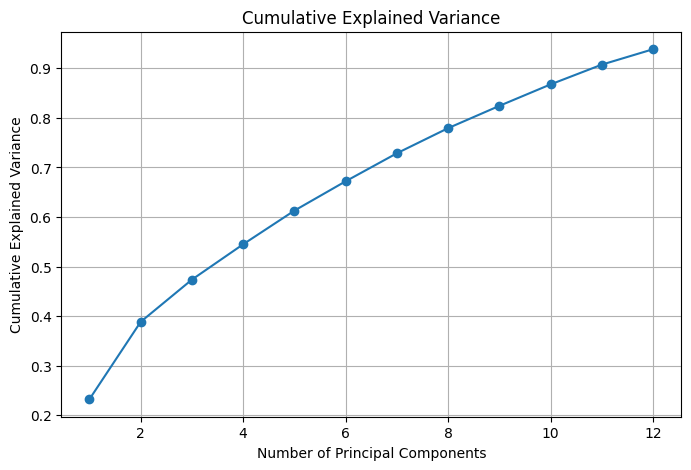

In [69]:
from sklearn.decomposition import PCA
# Plot explained variance ratio
pca = PCA(n_components=12)

# Fit PCA on your data and transform it to get the new, smaller features.
x_pca = pca.fit_transform(x_train_scaled)
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()
# This means the first 15 principal components together explain 95% or 97% of the total variance so we will keep only 15 

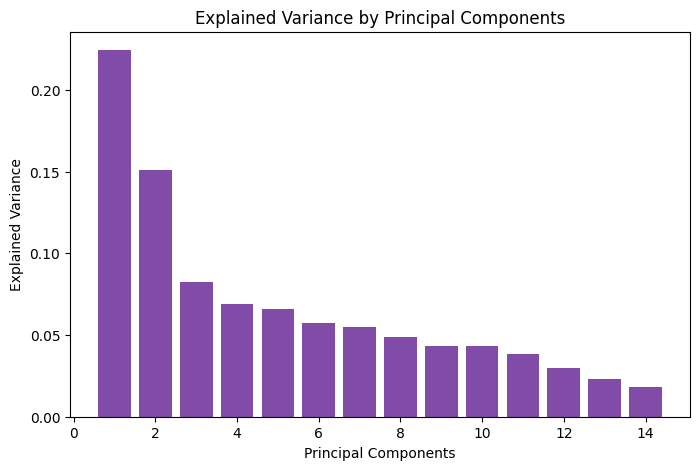

In [73]:
# Let's say you already have your features in X (only numeric ones)
# For our example, we want to reduce our features to 2 principal components.
pca = PCA(n_components=0.95)
# pca = PCA(n_components=0.95) or in my case i can use 0.95 becuase 14 pc's are equal to 95% variance in my dataset 

# Fit PCA on your data and transform it to get the new, smaller features.
x_pca = pca.fit_transform(x_train_scaled)

explained_variance = pca.explained_variance_ratio_
plt.figure(figsize=(8,5))
plt.bar(range(1, 15), explained_variance, alpha=0.7, color=color2)
plt.xlabel("Principal Components")
plt.ylabel("Explained Variance")
plt.title("Explained Variance by Principal Components")
plt.show()

In [ ]:
# import time
# from sklearn.metrics import accuracy_score
# from sklearn.ensemble import RandomForestClassifier

# # Initialize the model
# model = RandomForestClassifier(random_state=42)

# Before PCA
# start_time = time.time()
# model.fit(X_train, y_train)
# end_time = time.time()
# training_time_before = end_time - start_time

# # Predictions
# y_pred_before = model.predict(X_test)

# # Accuracy Before PCA
# accuracy_before = accuracy_score(y_test, y_pred_before)

# print("Training Time Before PCA:", training_time_before)
# print("Accuracy Before PCA:", accuracy_before)

# # Apply PCA
# pca = PCA(n_components=12)  # i will Keep 12 components
# X_train_pca = pca.fit_transform(X_train)
# X_test_pca = pca.transform(X_test)

# # After PCA
# start_time = time.time()
# model.fit(X_train_pca, y_train)
# end_time = time.time()
# training_time_after = end_time - start_time

# # Predictions
# y_pred_after = model.predict(X_test_pca)

# # Accuracy After PCA
# accuracy_after = accuracy_score(y_test, y_pred_after)

# print("Training Time (After PCA):", training_time_after)
# print("Accuracy (After PCA):", accuracy_after)

# # Compare Results
# print("\n--- Comparison ---")
# print(f"Training Time Reduced? {'Yes' if training_time_after < training_time_before else 'No'}")
# print(f"Accuracy Change: {accuracy_after - accuracy_before:.4f}")

# the result is 
# Training Time Before PCA: 223.3123242855072
# Accuracy Before PCA: 0.80528835194894
# Training Time After PCA: 229.27585411071777
# Accuracy After PCA: 0.8037991034115949


# it means it cauldn't improved accuracy and speed so we won't use it 
